In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import scipy as sp

# Roots

In [29]:
def horner(a, x):
    p = a[-1]
    for i in a[-2::-1]:
        p = i + x*p
    return p

In [30]:
def newton(f, df, x0, nmax):
    x = x0
    iterates = [x0]
    for n in range(nmax):
        x = x - f(x)/df(x)
        iterates.append(x)
    return iterates

In [31]:
def secant(f, x0, x1, n_max):
    a = x0
    b = x1
    f_a = f(a)
    f_b = f(b)
    X = [a, b]
    for n in range(1,n_max, 1):
        d = f_b * (b-a)/(f_b - f_a)
        a = b
        f_a = f_b
        b = b - d
        f_b = f(b)
        X.append(b)
    return X

# Data Fitting

In [4]:
xy = np.load('FitData.npy')
x = xy[:,0]
y = xy[:,1]

In [5]:
A = np.array([np.ones(len(x)), x, np.sin(x), np.cos(x), np.sin(2*x), np.cos(2*x)]).T
y = np.array([y]).T
c = np.linalg.solve(A.T@A,A.T@y)

In [6]:
xx = np.linspace(min(x), max(x), 100)
yy = c[0] + c[1]*xx + c[2]*np.sin(xx) + c[3]*np.cos(xx) + c[4]*np.sin(2*xx) + c[5]*np.cos(2*xx)

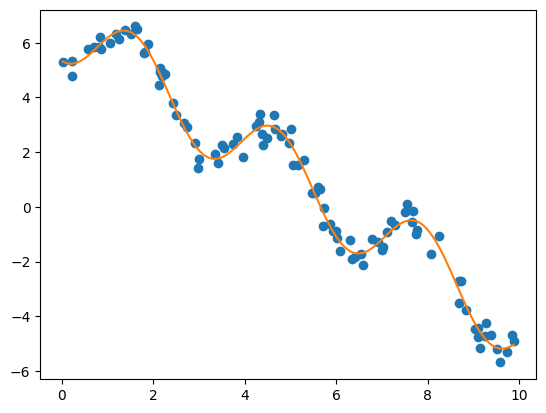

In [7]:
plt.plot(x,y,'o')
plt.plot(xx,yy)

# Interpolation

In [18]:
def CardinalPolynomial(nodes, i, t):
    cardinals = []
    #loop that calculates ith polynomial
    for arg in t: 
        l = 1
        for index in range(len(nodes)):
            if index == i:              #skips ith node 
                continue
            else:
                l*=(arg-nodes[index])/(nodes[i]-nodes[index])  #calculates multipliers for the polynomial l_arg, l_arg = lmb(1)lmb(2)...lmb(index)...
        cardinals.append(l)
    return cardinals

def InterpolerLagrangeForm(nodes, ydata, t):
    ydata = np.r_[*ydata].reshape(-1, 1)
    nodes = np.r_[*nodes]
    cardinals_matrix = []

    for i in range(len(nodes)):
        cardinals = np.array(CardinalPolynomial(nodes, i, t)).T   #adds column to the matrix [l_i(t_0), l_i(t_1), ..., l_i(t_n)]
        cardinals_matrix.append(cardinals)

    cardinals_matrix = np.column_stack(cardinals_matrix)
    langrange = cardinals_matrix @ ydata

    return langrange

In [17]:
x = [1,2.5,3,5]
y = [1,2,3,4]
t = np.linspace(0.5,5.5,200)
#InterpolerLagrangeForm(x, y, t)

# Integration

In [22]:
def MinTrapez(f, a, b, n):
    if b > a:
        h = (b-a)/n
    else:
        h = (a-b)/n
    boundry_sum = f(a) + f(b)
    mid_sum = 0
    for i in range(1,n, 1):
        mid_sum += 2*f(a+h*i)
    integral = h/2 * (mid_sum + boundry_sum)
    return integral

### Trapezoid rule error 
\begin{equation}
|E_t| \leq \frac{1}{12} h^3 \max_{a \leq \xi \leq b} |f''(\xi)|.
\end{equation}
\begin{gather}
E_t = -\frac{(b-a)h^2}{12} \left( \frac{1}{n} \sum_{i=1}^n f''(\xi_i) \right) = -\frac{(b-a)h^2}{12} f''(\zeta), 
\text{with } a < \zeta < b.
\end{gather}
The error is $\mathcal{O}(h^2)$, i.e., it is proportional to $h^2$ and $\frac{1}{n^2}$.


In [21]:
def Simpson(f, interval, n):
    if n%2 != 0:
        print("Error!!! n must be even!!!")
        return 0
    a = interval[0]
    b = interval[1]
    h = (b-a)/2
    Area = 0
    for i in range(n-1):
        #Area += h/3*(f(a+(i-1)*h) + 4*f(a+(2*i-1)*h/2)+f(a+i*h))   if i goes from 0, but more multiplications
        Area += h/3*(f(a) + 4*f(a+h/2) + f(a+h)) 
        a = a + h
    return Area

### Simpson rule error
\begin{equation}
E_t = -\frac{h^5}{90} f^{(4)}(\xi) \text{ for a } \xi \in (a, b).
\end{equation}

Composite Simpson Rule error
\begin{equation}
E_t = -\frac{(b-a)^5}{180n^4} f^{(4)}(\xi) \text{ for a } \xi \in (a, b).
\end{equation}

# Diff Eqautions

In [24]:
def MyTaylor2(a,b,x0,n,der): #der- list of derivatives
    t = a
    h = (b-a)/n
    res = [(0, t, x0)]
    x= x0 
    for i in range(1,n+1,1):
        x = x + h*(der[0](x,t) + 0.5*h*der[1](x,t))
        t = a + i*h
        res.append((i,t,x))
    return res

### Local Truncation Error

\begin{equation}
\frac{1}{(k+1)!} x^{(k+1)}(\xi) h^{k+1}, \quad \text{some } \xi \in (a, b)
\end{equation}

In [25]:
def MyRK4(dxdt, tspan, x0, n):
    t = tspan[0]
    h = (tspan[1] - tspan[0])/n
    x = x0
    res = [(0,t,x)]
    for i in range(1,n+1,1):
        K1 = h*dxdt(x, t)
        K2 = h*dxdt(x + 0.5*K1, t + 0.5*h)
        K3 = h*dxdt(x + 0.5*K2, t + 0.5*h)
        K4 = h*dxdt(x + K3, t + h)
        x = x + 1/6*(K1+2*K2+2*K3+K4)
        t = tspan[0] + i*h
        res.append((i,t,x))
    return res

In [26]:
def MyRK4System(sys, tspan, x0, n):
    if x0.shape[0] != sys(tspan[0],x0).shape[0]:
        print("Wrong dimensions of x0 and system")
        return
    t = tspan[0]
    h = (tspan[1] - tspan[0])/n
    x = x0
    t_vec = []
    MX = []
    MX.append(x)
    t_vec.append(t)
    for i in range(1,n+1):
        K1 = h*sys(t, x)
        K2 = h*sys(t + 0.5*h, x + 0.5*K1)
        K3 = h*sys(t + 0.5*h, x + 0.5*K2)
        K4 = h*sys(t + h, x + K3)
        x = x + 1/6*(K1+2*K2+2*K3+K4)
        t = tspan[0] + i*h
        MX.append(x)
        t_vec.append(t)
    return t_vec, MX

In [28]:
def secant_update(mu_0, mu_1, x2_mu0, x2_mu1, target):
    psi_mu0 = x2_mu0 - target
    psi_mu1 = x2_mu1 - target
    mu_2 = mu_1 - psi_mu1 * (mu_1 - mu_0) / (psi_mu1 - psi_mu0)
    return mu_2

\begin{equation}
    \mu_{k+1} = \mu_k - \frac{\mu_{k-1} - \mu_{k}}{\psi(\mu_{k-1}) - \psi(\mu_{k})}\psi(\mu_k)
\end{equation}
Where $\psi(\mu) = \mu_k - desired $


# System of Equations

### Newton Method

In [34]:
from Newtonsys import Newtonsys
def FdF201(X):
    x1, x2, x3 = X
    F1 = x1 + x2 + x3
    F2 = x1**2 + x2**2 + x3**2 - 2
    F3 = x1*(x2+x3) + 1

    F = np.array([F1, F2, F3])
    dF = np.array([[1,1,1],[2*x1, 2*x2, 2*x3],[x2+x3,x1,x1]])
    
    return F, dF
X0 = np.array([3/4, 1/2, -1/2])
Xiter = Newtonsys(FdF201,X0,10)

In [35]:
A = np.array([[3,12,13],[12,0,12],[0,2,30]])
P, L, U = sp.linalg.lu(A)
#display(P, L, U)